## Import Packages

In [27]:
using JuMP;
using Plots;
using HiGHS;
using CSV;
using DataFrames;
using MarketData;
using StatsPlots;

## Load Data

In [4]:
function load_data(stocks::Array{String}, years::Int64)
    output = Array{Float64}[]
    t = Dates.now()
    period = YahooOpt(period1 = t - Year(years), period2 = t)
    for stock in stocks
        data = yahoo(stock, period)
        value = (values(data["High"]) + values(data["Low"]))/2;
        push!(output, value)
    end
    return hcat(output...)
end

function evaluate_factor(data::Matrix{Float64})
    m, n = size(data) 
    factor = zeros(m-1,n)
    mean = zeros(n)

    for i in 1:m-1
        factor[i,:] = (data[i+1,:] - (data[i,:])) ./ (data[i,:])
    end
    return factor
end

data = load_data(["PETR4.SA", "VALE3.SA", "AZUL4.SA", "BPAC11.SA"], 1);
factor = evaluate_factor(data);

## Model

In [31]:
function portifolio(factor::Matrix{Float64}; fixed::Float64 = 0.0, β::Float64 = 0.0, α::Float64 = 0.05, BigM::Float64 = 1e3)

    m, n = size(factor) 
    p = 1/m
    
    model = Model(HiGHS.Optimizer)
    MOI.set(model, JuMP.MOI.Silent(), true)
    
    @variable(model, x[1:n] >= 0.0)
    @variable(model, y[1:m], Bin)
    
    @constraint(model, sum(x) <= 1.0)
    @constraint(model,[i = 1:m], fixed*(1-sum(x)) + sum(factor[i,j]*x[j] for j in 1:n) >= β - BigM*y[i])
    @constraint(model, sum(y*p) <= α)

    @objective(model, Max, sum(factor[i,j]*p*x[j] for i = 1:m, j = 1:n) + fixed*(1-sum(x)))

    optimize!(model)
    
    return model
end

portifolio (generic function with 1 method)

In [47]:
#model = portifolio_simple(factor, β = -1.0, α = 0.05)
#@show value.(model[:x])
#@show 1-sum(value.(model[:x]))

function portifolios(factor::Matrix{Float64}, Β::Vector{Float64}, α::Float64 = 0.05)
    m, n = size(factor) 
    b = length(Β)
    values = zeros(b, n+1)
    for i in 1:b
        model = portifolio(factor, β = Β[i], α = α)
        values[i,1] = 1-sum(value.(model[:x]))
        values[i,2:end] = value.(model[:x])
    end
    return values
end

portifolios (generic function with 4 methods)

## Plots

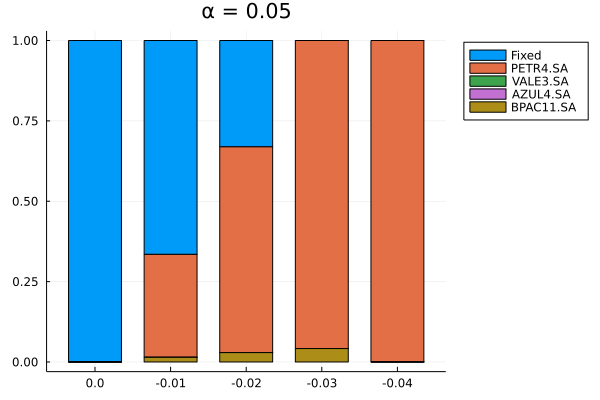

In [57]:
α = 0.05
Β = [0.0, -0.01, -0.02, -0.03, -0.04]
Β_string = string.(Β)
data = portifolios(factor, Β, α)

# In PyPlot backend, if we use chars like 'A':'L', ticks are displayed with "PyWrap".
ticklabel = Β_string
groupedbar(data,
        title = "α = $(α)",
        legend = :outertopright,
        bar_position = :stack,
        bar_width=0.7,
        xticks=(1:length(Β_string), ticklabel),
        label=["Fixed" "PETR4.SA" "VALE3.SA" "AZUL4.SA" "BPAC11.SA"])